In [10]:
import os
import torch
import torch.nn as nn
import math
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)
from pytorch3d.vis.plotly_vis import plot_batch_individually
from pytorch3d.ops.points_normals import estimate_pointcloud_normals
from pytorch3d.ops.mesh_face_areas_normals import mesh_face_areas_normals
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:2")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [11]:
trg_obj = 'Geographos Radar-based, low-res(1).obj'
# 读取卫星各项参数
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale *5

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

# 为mesh添加材质信息
verts_rgb = torch.ones_like(trg_mesh.verts_packed())*255  # 使用纯白色作为默认颜色
verts_rgb = verts_rgb.unsqueeze(0)
textures = TexturesVertex(verts_features=verts_rgb)
trg_mesh.textures = textures

/home/hkz/.conda/envs/3d_env/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:546: UserWarning:

No mtl file provided



In [12]:
# 创建初始模型，球形
sphere1 = ico_sphere(4, device)
sphere2 = ico_sphere(4, device)

# 平移第二个球体，使它与第一个球体黏连
# 获取第一个球体的最大 x 坐标
max_x = sphere1.verts_packed()[:, 0].max()

# 获取第二个球体的顶点并进行x方向平移
shift = max_x - 0.1  # 确保轻微重叠
verts2 = sphere2.verts_packed() + torch.tensor([shift, 0, 0], device=device)

# 获取第一个球体的顶点并且平移
verts1 = sphere2.verts_packed() + torch.tensor([-shift, 0, 0], device=device)

# 合并两球体的顶点
verts = torch.cat([verts1, verts2], dim=0)

# 合并面片，并更新第二个球体的面片索引
faces1 = sphere1.faces_packed()
faces2 = sphere2.faces_packed() + sphere1.verts_packed().shape[0]  # 更新索引

# 合并面片数据
faces = torch.cat([faces1, faces2], dim=0)

# 创建黏连的球体网格
src_mesh = Meshes(verts=[verts], faces=[faces])


verts = src_mesh.verts_packed()
faces = src_mesh.faces_packed()
scaled_verts = verts * 2

trg_mesh = Meshes(verts=[scaled_verts], faces=[faces])

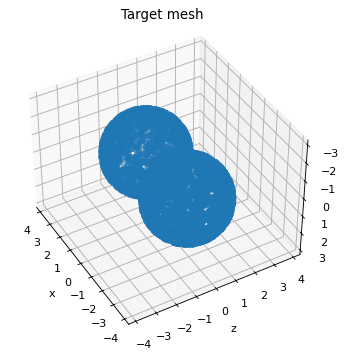

In [13]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(220, 30)
    ax.axis('equal')
    plt.show()

plot_pointcloud(trg_mesh, "Target mesh")
plot_batch_individually(trg_mesh)

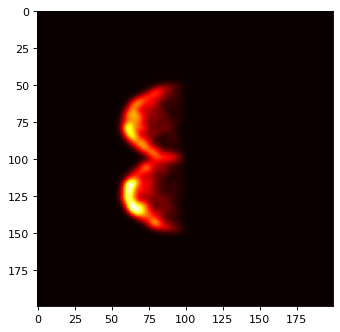

In [14]:
def round_to_axis(var,start,end,num):
    idx = torch.round((var - start)/(end-start) * (num-1))
    if idx < 0:
        idx 

def gaussian_pdf(x, mu, sigma):
    const = 1.0
    exp = torch.exp(-0.5 * ((x - mu) / sigma)**2)
    return const * exp

class ISAR_render(nn.Module):
    def __init__(self, device) -> None:
        super().__init__()
        self.c = torch.tensor([299792458.0], device=device)
        self.Tcoh = torch.tensor([30], device=device)
        self.PRF = torch.tensor([20.0], device=device)
        self.fc = torch.tensor([9.7e9], device=device)
        self.Tp = torch.tensor([5e-4], device=device)
        self.B = torch.tensor([100e7], device=device)
        self.Range_map,self.Dopple_map = torch.meshgrid(torch.linspace(-5,5,200).to(device),torch.linspace(-3,3,200).to(device), indexing='xy')
        self.lambda1 = self.c/self.fc
        self.RangeRes = self.c/self.B/2
        self.complex_i = torch.tensor([1j], dtype=torch.complex64, device=device)

    def forward(self, mesh, RadarLos, SpinAxis, Omega):
        # 输入
        # mesh为pytorch3d自带的结构，采样后采样点为：sampled_points [batchsize,N,3] point_normals [batchsize,N,3]
        # 雷达视线方向 RadarLos [batchsize,3]
        # 转轴 SpinAxis [batchsize,3]
        sampled_points,point_normals = sample_points_from_meshes(mesh, 2000, return_normals=True)
        DopplerAxis = torch.cross(RadarLos,SpinAxis,dim = -1)
        point_vel = torch.cross(SpinAxis.unsqueeze(1),sampled_points,dim = -1)
        point_vel_Radial = Omega * torch.sum(RadarLos.unsqueeze(1)*point_vel,dim=2)
        point_doppler = -2*point_vel_Radial/self.lambda1
        point_range = torch.sum(RadarLos.unsqueeze(1)*sampled_points,dim=2)
        point_Amp = torch.sum(RadarLos.unsqueeze(1)*point_normals, dim=2)
        point_Amp = torch.clamp(point_Amp,max=0)
        DopplerRes = self.lambda1/2/Omega/self.Tcoh

        # range_idx = torch.round
        
        # image_AllPoint = torch.sinc(1/self.RangeRes*(self.Range_map.unsqueeze(0).unsqueeze(1)-point_range.unsqueeze(2).unsqueeze(3))) * torch.sinc(1/DopplerRes*(self.Dopple_map.unsqueeze(0).unsqueeze(1)-point_doppler.unsqueeze(2).unsqueeze(3))) * torch.exp(-4*math.pi*self.complex_i/self.lambda1*point_range.unsqueeze(2).unsqueeze(3))
        # image_AllPoint = point_Amp.unsqueeze(2).unsqueeze(3)*torch.sinc(1/self.RangeRes*(self.Range_map.unsqueeze(0).unsqueeze(1)-point_range.unsqueeze(2).unsqueeze(3))) * torch.sinc(1/DopplerRes*(self.Dopple_map.unsqueeze(0).unsqueeze(1)-point_doppler.unsqueeze(2).unsqueeze(3))) * torch.exp(-4*math.pi*self.complex_i/self.lambda1*point_range.unsqueeze(2).unsqueeze(3))
        # # image_AllPoint = torch.abs(point_Amp.unsqueeze(2).unsqueeze(3)*torch.sinc(1/self.RangeRes*(self.Range_map.unsqueeze(0).unsqueeze(1)-point_range.unsqueeze(2).unsqueeze(3))) * torch.sinc(1/DopplerRes*(self.Dopple_map.unsqueeze(0).unsqueeze(1)-point_doppler.unsqueeze(2).unsqueeze(3))) * torch.exp(-4*math.pi*self.complex_i/self.lambda1*point_range.unsqueeze(2).unsqueeze(3)))
        image_AllPoint = point_Amp.unsqueeze(2).unsqueeze(3)*gaussian_pdf(point_range.unsqueeze(2).unsqueeze(3), self.Range_map.unsqueeze(0).unsqueeze(1), self.RangeRes) * gaussian_pdf(point_doppler.unsqueeze(2).unsqueeze(3), self.Dopple_map.unsqueeze(0).unsqueeze(1), DopplerRes)
        image = torch.sum(image_AllPoint,dim=1)

        return image

ISAR_render1 = ISAR_render(device)

RadarLos = torch.tensor([-1/2,0,-math.sqrt(3)/2], device=device)
RadarLos = torch.tensor([0,math.sqrt(3)/2,-1/2], device=device)
RadarLos = torch.tensor([0,math.sqrt(3)/2,-1/2], device=device)
SpinAxis = torch.tensor([0,0,1.0], device=device)
Omega = torch.tensor([2*math.pi/900], device=device)
RadarLos = RadarLos.unsqueeze(0)
SpinAxis = SpinAxis.unsqueeze(0)
Omega = Omega.unsqueeze(0)

image = ISAR_render1(trg_mesh,RadarLos,SpinAxis,Omega)

image_clone = image.clone().squeeze(0).detach().cpu()
image_abs = torch.abs(image_clone).numpy()

plt.imshow(image_abs,cmap='hot')

In [15]:
# 生成12组雷达视线方向
def vec_rot(vec,axis_x,axis_y,axis_z,theta):

    axis_x = axis_x.expand(theta.shape)
    axis_y = axis_y.expand(theta.shape)
    axis_z = axis_z.expand(theta.shape)

    c = torch.cos(theta)
    s = torch.sin(theta)
    one_c = 1 - c

    Rotmat = torch.stack([
        torch.stack([axis_x**2 * one_c + c, axis_x * axis_y * one_c - axis_z * s, axis_x * axis_z * one_c + axis_y * s], dim=-1),
        torch.stack([axis_x * axis_y * one_c + axis_z * s, axis_y**2 * one_c + c, axis_y * axis_z * one_c - axis_x * s], dim=-1),
        torch.stack([axis_x * axis_z * one_c - axis_y * s, axis_y * axis_z * one_c + axis_x * s, axis_z**2 * one_c + c], dim=-1)
    ], dim=-2)

    vec_rot = torch.matmul(Rotmat,vec.unsqueeze(1)).squeeze(2)

    return vec_rot

batch = 50

RadarLos = torch.tensor([-1.0,0,0], device=device)
theta = torch.linspace(0,2*math.pi,batch).to(device)

axis_x = torch.tensor([0.0], device=device)
axis_y = torch.tensor([0.0], device=device)
axis_z = torch.tensor([1.0], device=device)
Round_radar_los = vec_rot(RadarLos,axis_x,axis_y,axis_z,theta)

print(Round_radar_los)
print(Round_radar_los.shape)

tensor([[-1.0000e+00,  0.0000e+00,  0.0000e+00],
        [-9.9179e-01, -1.2788e-01,  0.0000e+00],
        [-9.6729e-01, -2.5365e-01,  0.0000e+00],
        [-9.2692e-01, -3.7527e-01,  0.0000e+00],
        [-8.7132e-01, -4.9072e-01,  0.0000e+00],
        [-8.0141e-01, -5.9811e-01,  0.0000e+00],
        [-7.1835e-01, -6.9568e-01,  0.0000e+00],
        [-6.2349e-01, -7.8183e-01,  0.0000e+00],
        [-5.1839e-01, -8.5514e-01,  0.0000e+00],
        [-4.0478e-01, -9.1441e-01,  0.0000e+00],
        [-2.8453e-01, -9.5867e-01,  0.0000e+00],
        [-1.5960e-01, -9.8718e-01,  0.0000e+00],
        [-3.2052e-02, -9.9949e-01,  0.0000e+00],
        [ 9.6023e-02, -9.9538e-01,  0.0000e+00],
        [ 2.2252e-01, -9.7493e-01,  0.0000e+00],
        [ 3.4537e-01, -9.3847e-01,  0.0000e+00],
        [ 4.6254e-01, -8.8660e-01,  0.0000e+00],
        [ 5.7212e-01, -8.2017e-01,  0.0000e+00],
        [ 6.7230e-01, -7.4028e-01,  0.0000e+00],
        [ 7.6145e-01, -6.4823e-01,  0.0000e+00],
        [ 8.3809e-01

In [16]:
# # 生成36组雷达视线方向
# def vec_rot(vec,axis_x,axis_y,axis_z,theta):

#     axis_x = axis_x.expand(theta.shape)
#     axis_y = axis_y.expand(theta.shape)
#     axis_z = axis_z.expand(theta.shape)

#     c = torch.cos(theta)
#     s = torch.sin(theta)
#     one_c = 1 - c

#     Rotmat = torch.stack([
#         torch.stack([axis_x**2 * one_c + c, axis_x * axis_y * one_c - axis_z * s, axis_x * axis_z * one_c + axis_y * s], dim=-1),
#         torch.stack([axis_x * axis_y * one_c + axis_z * s, axis_y**2 * one_c + c, axis_y * axis_z * one_c - axis_x * s], dim=-1),
#         torch.stack([axis_x * axis_z * one_c - axis_y * s, axis_y * axis_z * one_c + axis_x * s, axis_z**2 * one_c + c], dim=-1)
#     ], dim=-2)

#     vec_rot = torch.matmul(Rotmat,vec.unsqueeze(1)).squeeze(2)

#     return vec_rot

# batch = 12

# RadarLos1 = torch.tensor([-1.0,0,0], device=device)
# RadarLos2 = torch.tensor([-1/2,0,-math.sqrt(3)/2], device=device)
# RadarLos3 = torch.tensor([-1/2,0,math.sqrt(3)/2], device=device)
# theta = torch.linspace(0,2*math.pi,batch).to(device)

# axis_x = torch.tensor([0.0], device=device)
# axis_y = torch.tensor([0.0], device=device)
# axis_z = torch.tensor([1.0], device=device)
# Round_radar_los1 = vec_rot(RadarLos1,axis_x,axis_y,axis_z,theta)
# Round_radar_los2 = vec_rot(RadarLos2,axis_x,axis_y,axis_z,theta)
# Round_radar_los3 = vec_rot(RadarLos3,axis_x,axis_y,axis_z,theta)

# Round_radar_los = torch.cat([Round_radar_los1,Round_radar_los2,Round_radar_los3],dim=-2)
# print(Round_radar_los)
# print(Round_radar_los.shape)

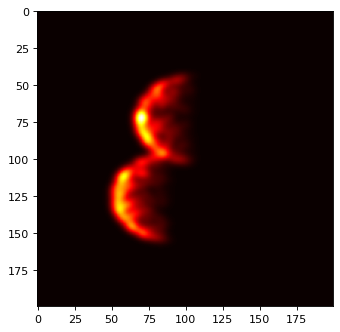

In [17]:
# 渲染多组图片并将其保存起来
batch = 36
batchsize = 3
image_batch = torch.zeros(batch,200,200)
for i in range(int(batch/batchsize)):
    image_batch[i*batchsize:(i+1)*batchsize,:,:] = ISAR_render1(trg_mesh,Round_radar_los[i*batchsize:(i+1)*batchsize,:],SpinAxis,Omega)
    for j in range(batchsize):
        image_name = './test/image'+ str(i*batchsize+j) + '.png'
        image_clone = image_batch[i*batchsize+j,:,:].clone().squeeze(0).detach().cpu()
        image_abs = torch.abs(image_clone).numpy()
        plt.imsave(image_name, image_abs)

np.savez('./test/images.npz', image_batch=image_batch)


plt.imshow(image_abs,cmap='hot')